In [1]:
import re
import os
import torch
import random
import string
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import uniform, randint
from scipy.sparse import vstack
from top2vec import Top2Vec

In [2]:
# random seeds
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

### Initial shallow model using LDA

In [3]:
# helper functions
def load_data(path):
    return pd.read_csv(path, index_col=False).drop(columns= ['Unnamed: 0','journal', 'year'])
    
def pre_process(text):
    text = text.lower()
    text = re.sub('\d+', ' N ', text)
    text = re.sub('[^\w^\s]+', ' P ', text)
    text = re.sub('\s+', ' ', text)
    return text

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [4]:
# loading and processing data
df = load_data('./data/task2/als_literature.csv')
print(f'{len(df[df.title.isna()])} examples have no title or abstract and are removed')
df = df.dropna(subset=['title'])
# now we fill the empty abstracts
df.abstract = df.abstract.fillna('')
df.abstract = df.abstract.apply(pre_process)
df.title = df.title.apply(pre_process)

32 examples have no title or abstract and are removed


In [7]:
# vectorizing 
titles_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                    stop_words='english',
                                    max_df=0.95,min_df = 5)
abs_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                    stop_words='english',
                                    max_df=0.95,min_df = 5)
x_title = titles_vectorizer.fit_transform(df.title.to_list())
x_abs = abs_vectorizer.fit_transform(df.abstract.to_list())

svd = TruncatedSVD(n_components=512)
x_title_cont = svd.fit_transform(x_title)
svd = TruncatedSVD(n_components=512)
x_abs_cont = svd.fit_transform(x_abs)

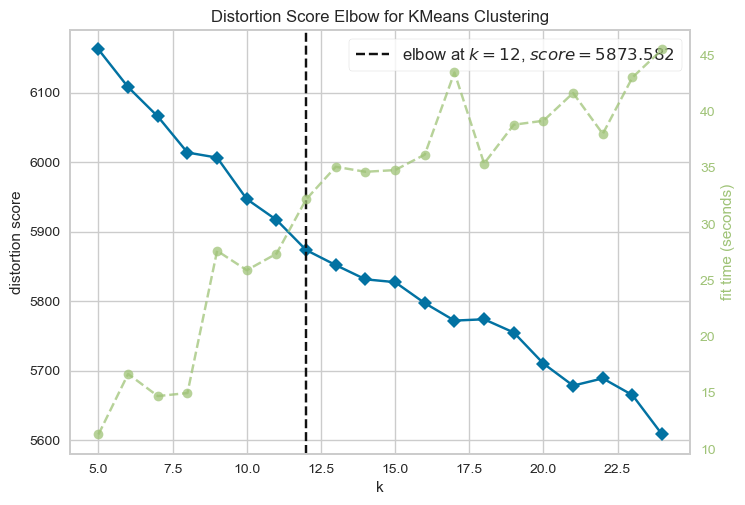

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# next we use Kmeans to get an initial estimate of the number of clusters
#  we are doing this on the titles for now 

model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,25))

visualizer.fit(x_abs_cont)        
visualizer.show()        

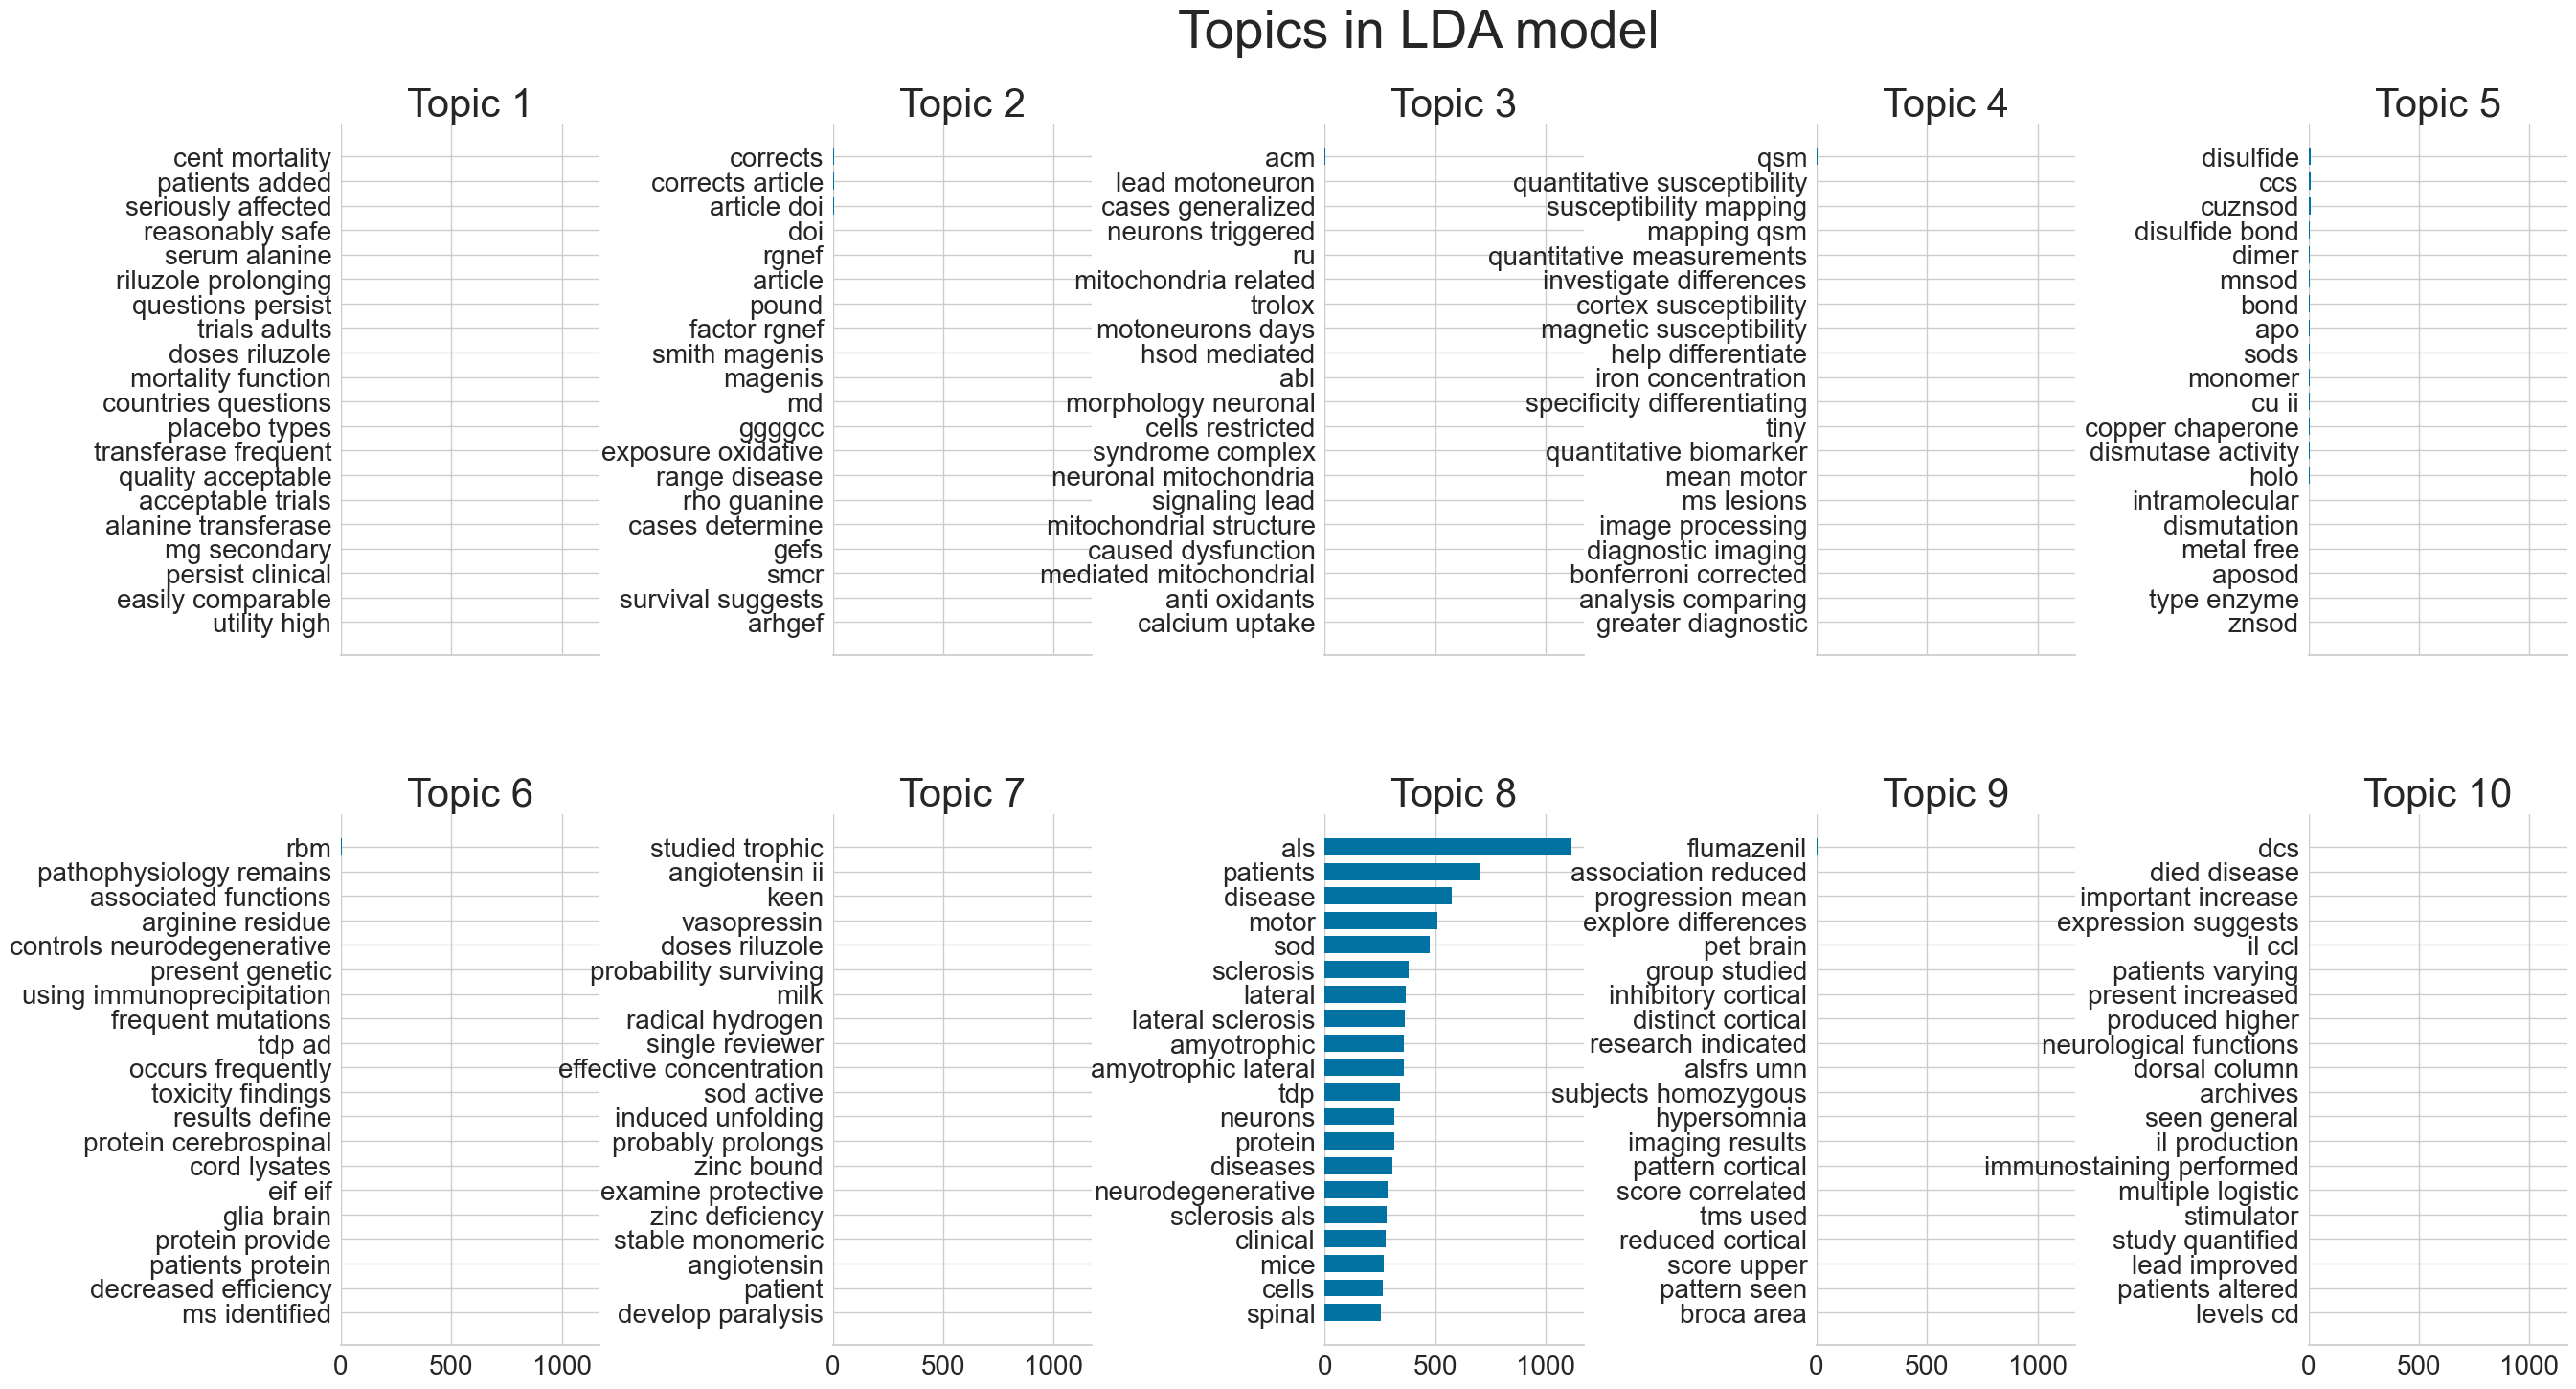

In [11]:
# next we train LDA I also did a bit of experimentation with the number of components
n_components = 10
n_top_words = 20
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(x_abs)

feature_names = abs_vectorizer.get_feature_names()
plot_top_words(lda, feature_names, n_top_words, 'Topics in LDA model')


## Deep approach

In [5]:
# just joining the title with the abstract 
df['all_text'] = [' '.join([el.title, el.abstract]) for el in df.itertuples()]

In [6]:
# training 
model = Top2Vec(documents=df.abstract.to_list(), speed="learn", workers=8)

2021-08-15 11:39:19,554 - top2vec - INFO - Pre-processing documents for training
2021-08-15 11:39:30,191 - top2vec - INFO - Creating joint document/word embedding
2021-08-15 11:49:47,230 - top2vec - INFO - Creating lower dimension embedding of documents
2021-08-15 11:50:24,585 - top2vec - INFO - Finding dense areas of documents
2021-08-15 11:50:27,384 - top2vec - INFO - Finding topics


In [7]:
# how many topics did the model find
print(f' the model found {model.get_num_topics()} different topics')

 the model found 248 different topics


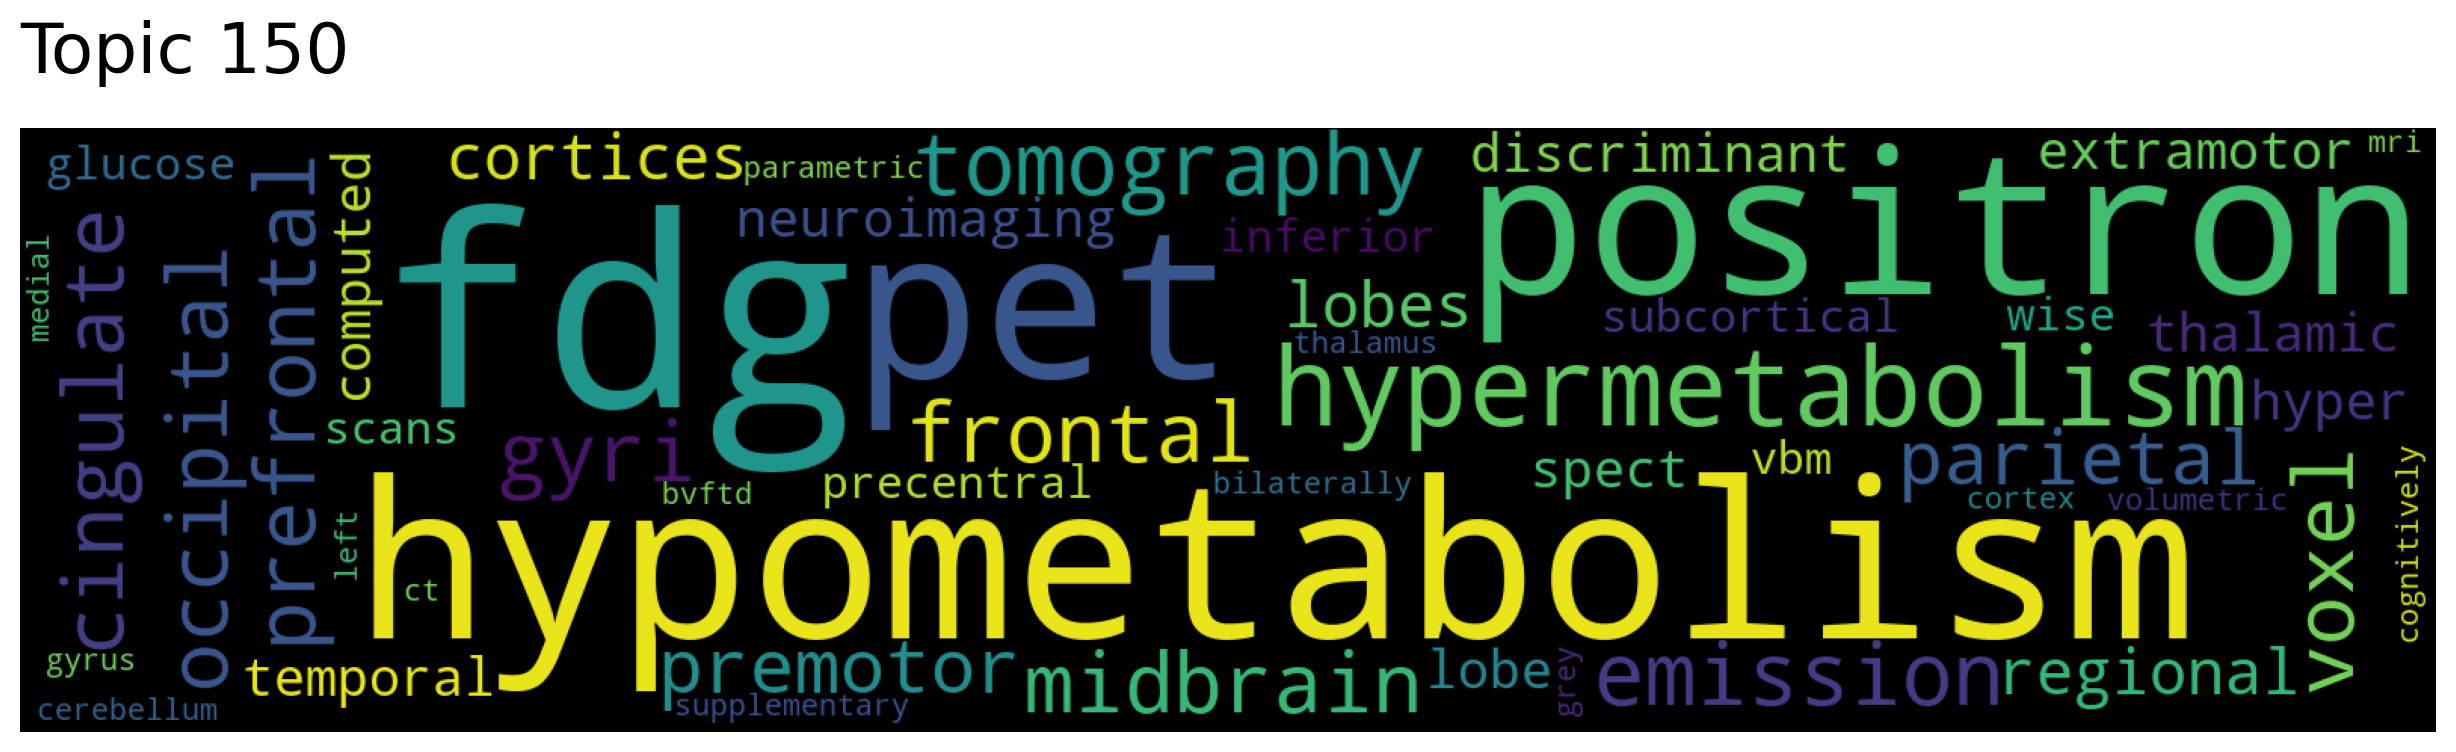

In [15]:
# inspecting some of the topics 
model.generate_topic_wordcloud(150, background_color='black', reduced=False)

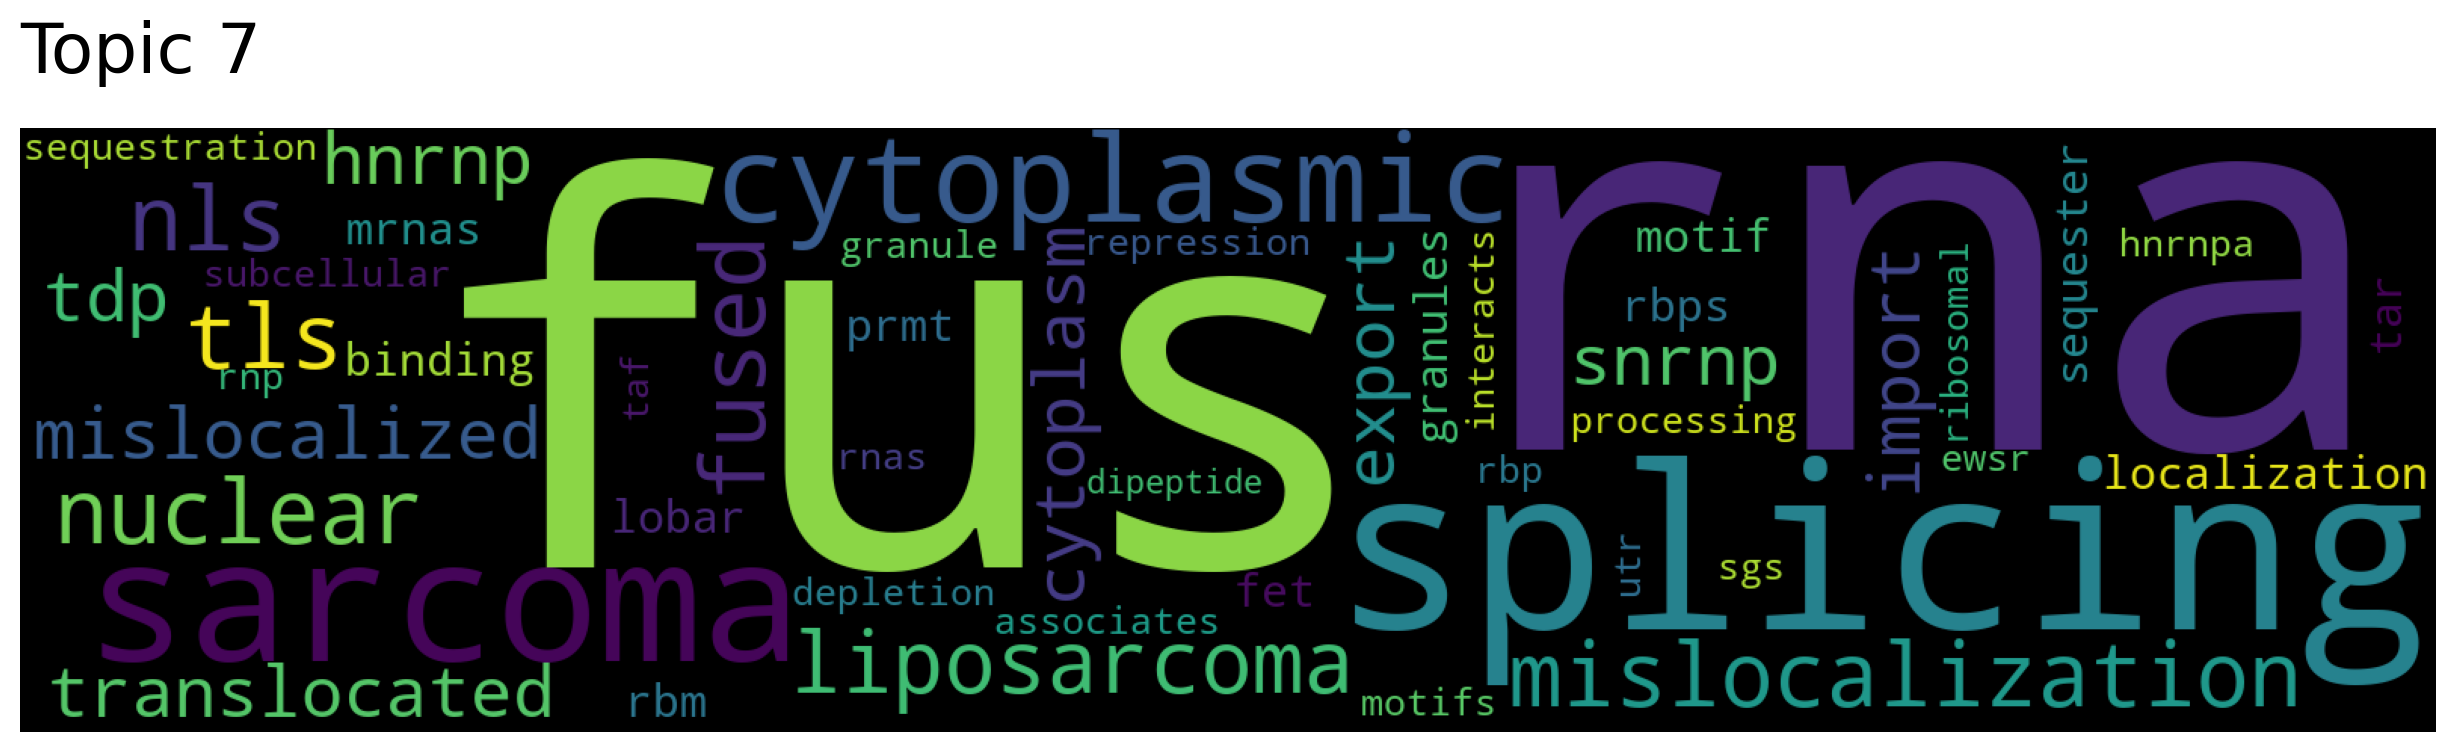

In [14]:
model.generate_topic_wordcloud(7, background_color='black', reduced=False)

In [12]:
# extracting the predicted topics
topic_nums, topic_score, _, _ =model.get_documents_topics(list(range(len(df))), num_topics=1)

In [13]:
# saving everythig to a text file 
df['topic_nums'] = topic_nums
df = df.drop(columns=['title', 'abstract'])
df.to_csv('./results_top2vec.txt')